In [1]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Pakete

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy.stats
#from scipy.stats import wilcoxon
import time
#import shap
import xgboost
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# Optimale Parameter
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

#SVM
from sklearn import svm
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib import cm

from sklearn import datasets
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score




# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Interpretation
import shap
shap.initjs()


In [2]:

# testdaten für die presi holen
import os
os.getcwd()
os.chdir(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

df = pd.read_csv('data/aidsenc.csv', sep =",")

In [3]:
df.shape

(2139, 17)

In [4]:
df.columns

Index(['Unnamed: 0', 'age', 'cd40', 'cid', 'trt_1', 'trt_2', 'trt_3', 'homo_1',
       'drugs_1', 'z30_1', 'gender_1', 'strat_2', 'strat_3', 'symptom_1',
       'hemo_1', 'race_1', 'ecog_1'],
      dtype='object')

In [5]:
# für weitere Tables 'Unnamed' Nummerierung enfernen
df = df.drop(["Unnamed: 0"],axis=1) #,"hemo", "race", "ecog"

# Datensatz 1. Reduktion

In [6]:
df.head(5)

,age,cd40,cid,trt_1,trt_2,trt_3,homo_1,drugs_1,z30_1,gender_1,strat_2,strat_3,symptom_1,hemo_1,race_1,ecog_1
0,48,422,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,61,162,1,0,0,1,0,0,1,0,0,1,0,0,0,0
2,45,326,0,0,0,1,1,1,1,1,0,1,0,0,0,0
3,47,287,0,0,0,1,1,0,1,1,0,1,0,0,0,0
4,43,504,0,0,0,0,1,0,1,1,0,1,0,0,0,0


In [ ]:
# df1-Datensatz für erste Modellrechnungen erstellen, der unveränderter, encodeder df-Datensatz kann im Verlauf aufgerufen werden
df1 = df

In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        2139 non-null   int64
 1   cd40       2139 non-null   int64
 2   cid        2139 non-null   int64
 3   trt_1      2139 non-null   int64
 4   trt_2      2139 non-null   int64
 5   trt_3      2139 non-null   int64
 6   homo_1     2139 non-null   int64
 7   drugs_1    2139 non-null   int64
 8   z30_1      2139 non-null   int64
 9   gender_1   2139 non-null   int64
 10  strat_2    2139 non-null   int64
 11  strat_3    2139 non-null   int64
 12  symptom_1  2139 non-null   int64
 13  hemo_1     2139 non-null   int64
 14  race_1     2139 non-null   int64
 15  ecog_1     2139 non-null   int64
dtypes: int64(16)
memory usage: 267.5 KB


## Datenspliting

In [9]:
X=df1.drop(['cid'],axis=1)
y=df1['cid']

In [10]:
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2,random_state=42)

print('X Train: {}'.format(X_train.shape)) 
print('Y Train: {}'.format(y_train.shape)) 
print('X Test: {}'.format(X_test.shape)) 
print('Y Test: {}'.format(y_test.shape))


X Train: (1711, 15)
Y Train: (1711,)
X Test: (428, 15)
Y Test: (428,)


## Transformierung mit MinMaxScaler

Die Entscheidung für die Normalisierung (und nicht die Standardisierung) wurde in Anbetracht der Ungewissheit, wie die unbekannten, neuen Test-Daten verteilt werden würden, getroffen.

In [11]:
#from sklearn.preprocessing import MinMaxScaler
mscaler = MinMaxScaler()

X_train['age'] = mscaler.fit_transform(X_train['age'].to_numpy().reshape(-1,1))
X_train['cd40'] = mscaler.fit_transform(X_train['cd40'].to_numpy().reshape(-1,1))

X_test['age'] = mscaler.fit_transform(X_test['age'].to_numpy().reshape(-1,1))
X_test['cd40'] = mscaler.fit_transform(X_test['cd40'].to_numpy().reshape(-1,1))


## Hyperparameter

Die Suche nach optimalen `C`, `gamma`, `kernel`, `max_depth` und `n_estimators` wurde mittels Random_Search durchgeführt. GRID-Research und Cross-Validierung dauerte zu lange. 

Per default ist Gamma 'scale', i.e. gamma = 1 / (n_features * X.var()). Es wird überlegt, die `gamma`='scale' statt dem optimierten wert zu nehmen.

<span style=color:green>Nota bene:</span>

`C` (Regularization Parameter): Controls the trade-off between a smooth decision boundary and correctly classifying training points.

`Kernel`: Specifies the function that transforms the input data into a higher-dimensional space to make it linearly separable.

`Gamma (γ)`: Determines how far the influence of a single training example reaches in non-linear kernels like RBF.

Die Doku vom [sklearn.model_selection](https://scikit-learn.org/stable/api/sklearn.model_selection.html).

In [12]:
# für LogReg

logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,
                              random_state=0)
distributions = dict(C=uniform(loc=0, scale=4),
                     penalty=['l2', 'l1'])
clf = RandomizedSearchCV(logistic, distributions, random_state=42)
search = clf.fit(X_train, y_train)

print("Die optimalen Hyperparameter für LogReg (Random Search):", search.best_params_)

Die optimalen Hyperparameter für LogReg (Random Search): {'C': np.float64(3.329770563201687), 'penalty': 'l1'}


In [13]:
# für SVM
param_dist = {
    'C': uniform(loc=0, scale=4),   #[0.1,1,10,100,1000]
    'gamma': [1,0.1,0.01,0.001,0.0001],
    'kernel': ['rbf', 'linear']
}

random_search = RandomizedSearchCV(SVC(random_state=42), param_dist, n_iter=10, refit=True,cv=5,verbose=0,random_state=42) #verbose = 0 : keine einzeln. Messages zu den fits
random_search.fit(X_train,y_train)

print("Die optimalen Hyperparameter für SVM (Random Seaarch):", random_search.best_params_)


Die optimalen Hyperparameter für SVM (Random Seaarch): {'C': np.float64(1.49816047538945), 'gamma': 0.0001, 'kernel': 'rbf'}


In [14]:
# für RF
param_dist = {'n_estimators': randint(10,300),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter=5, cv=5, random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000013D38FA8EB0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000013D38F76250>},
                   random_state=42)

In [15]:
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Die optimalen Hyperparameter für RF (Random Search):',  rand_search.best_params_)

Die optimalen Hyperparameter für RF (Random Search): {'max_depth': 7, 'n_estimators': 131}


## Die Auswahl des Classifikators

In [16]:
n_features = X.shape[1]

#C = 2.2

# Create different classifiers.
classifiers = {
    "L1 logistic": LogisticRegression(C=3.3, penalty="l1", solver="saga", max_iter=10000, random_state=42),
    
    "Linear SVC": SVC(kernel="linear", C=1.5, probability=True, random_state=42),
    
    "RBF SVC": SVC(kernel="rbf", C=1.5, gamma=0.0001, random_state=42),
    
    "Random Forest": RandomForestClassifier(max_depth=7, n_estimators=280, random_state=42)
}

for classifier_idx, (name, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    print(f"Akkuranz für {name}: {accuracy:0.2%}")
    print(f"Relevanz für {name}: {precision:0.2%}")
    print(f"Sensitivität für {name}: {recall:0.2%}")
    

Akkuranz für L1 logistic: 73.83%
Relevanz für L1 logistic: 23.81%
Sensitivität für L1 logistic: 4.95%
Akkuranz für Linear SVC: 76.40%
Relevanz für Linear SVC: 0.00%
Sensitivität für Linear SVC: 0.00%
Akkuranz für RBF SVC: 76.40%
Relevanz für RBF SVC: 0.00%
Sensitivität für RBF SVC: 0.00%
Akkuranz für Random Forest: 75.23%
Relevanz für Random Forest: 27.27%
Sensitivität für Random Forest: 2.97%


### gamma = 'scale'

In [17]:
# mit gamma = 'scale'
n_features = X.shape[1]

#C = 2.2

# Create different classifiers.
classifiers = {
    "L1 logistic": LogisticRegression(C=3.3, penalty="l1", solver="saga", max_iter=10000, random_state=42),
    
    "Linear SVC": SVC(kernel="linear", C=1.5, probability=True, random_state=42),
    
    "RBF SVC": SVC(kernel="rbf", C=1.5, gamma="scale", random_state=42),
    
    "Random Forest": RandomForestClassifier(max_depth=7, n_estimators=280, random_state=42)
}

for classifier_idx, (name, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    print(f"Akkuranz für {name}: {accuracy:0.2%}")
    print(f"Precision für {name}: {precision:0.2%}")
    print(f"Recall für {name}: {recall:0.2%}")
    

Akkuranz für L1 logistic: 73.83%
Precision für L1 logistic: 23.81%
Recall für L1 logistic: 4.95%
Akkuranz für Linear SVC: 76.40%
Precision für Linear SVC: 0.00%
Recall für Linear SVC: 0.00%
Akkuranz für RBF SVC: 75.47%
Precision für RBF SVC: 33.33%
Recall für RBF SVC: 3.96%
Akkuranz für Random Forest: 75.23%
Precision für Random Forest: 27.27%
Recall für Random Forest: 2.97%


Tendenz zu 'RBF SCV' mit `gamma`= 'scale'. ==> bessere Precision und Recall.

<span style=color:green>Precision steigern:</span> Also RBF SVC und Random Forest auf feature importnace / permutation importance anschauen. ==> Die Daten noch ein Mal reduzieren.

## Support Vector Machine: RBF-Kernel

`C` ist ein Regulierungsparameter. [Doku](https://scikit--learn-org.translate.goog/1.5/auto_examples/svm/plot_svm_scale_c.html?_x_tr_sl=en&_x_tr_tl=de&_x_tr_hl=de&_x_tr_pto=rq#sphx-glr-auto-examples-svm-plot-svm-scale-c-py) dazu. Die Anpassung von `C`, `gamma`und `kernel` s.o. 


Nota bene: [Enscheidungsgrenzen für das SVC anzeichnen](https://scikit--learn-org.translate.goog/1.5/auto_examples/svm/plot_svm_kernels.html?_x_tr_sl=en&_x_tr_tl=de&_x_tr_hl=de&_x_tr_pto=rq#sphx-glr-auto-examples-svm-plot-svm-kernels-py) dienen der Visualisierung der grundsätzlichen Wirkung des Kernels auf Daten. 

              precision    recall  f1-score   support

           0       0.98      0.77      0.86       416
           1       0.04      0.33      0.07        12

    accuracy                           0.75       428
   macro avg       0.51      0.55      0.46       428
weighted avg       0.95      0.75      0.84       428



Text(0.5, 0, 'Permutation Importance')

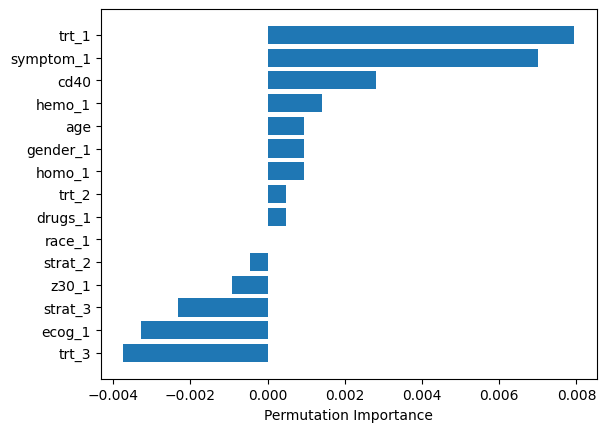

In [18]:
from sklearn.metrics import classification_report

clf =  SVC(kernel='rbf', C=1.5, gamma='scale', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_pred, y_test))

perm_importance = permutation_importance(clf, X_test, y_test)

feature_names = X_train.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

#'permutation importance' gibt wieder, wie wichtig ein feature für das vorliegende Modell ist.
# bei RBF sind die 'coef' nicht verfügbar. - keine feature importance.

In [19]:
#Accuracy im Traings- und Testdatensatz
# wie gut wurde getrennt? Der Unterschied ist nicht groß == guter Spliting

print("Akkuranz Train: {}".format(clf.score(X_train, y_train)))
print("Akkuranz Test: {}" .format(clf.score(X_test, y_test)))

Akkuranz Train: 0.7744009351256576
Akkuranz Test: 0.7546728971962616


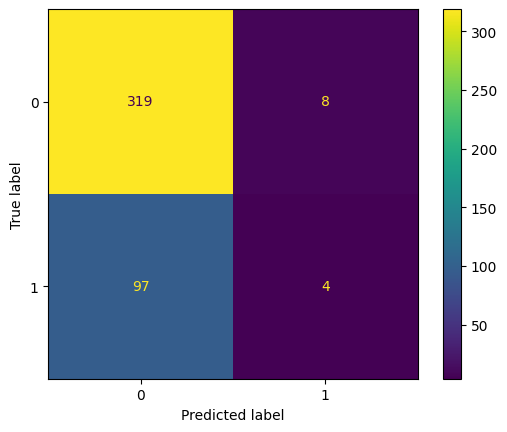

In [20]:
# Generate predictions with the best model
y_pred = clf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cm).plot();

## Random Forest

In [21]:
rf = RandomForestClassifier(max_depth=7, n_estimators=280, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Akkuranz RF Modell:", accuracy)

print(classification_report(y_pred, y_test))

Akkuranz RF Modell: 0.7523364485981309
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       417
           1       0.03      0.27      0.05        11

    accuracy                           0.75       428
   macro avg       0.50      0.52      0.46       428
weighted avg       0.95      0.75      0.84       428



`classification_report` liefert maue *Precision* sowohl für SVM als auch für RF für das Target = 1 (failure). Das ist ein deutlicher Hinweis auf unsymetrische Daten. Auch die Akkuranz ist mittelmässig.

Um so wichtiger ist es, unwichtige Features auszusortiren.

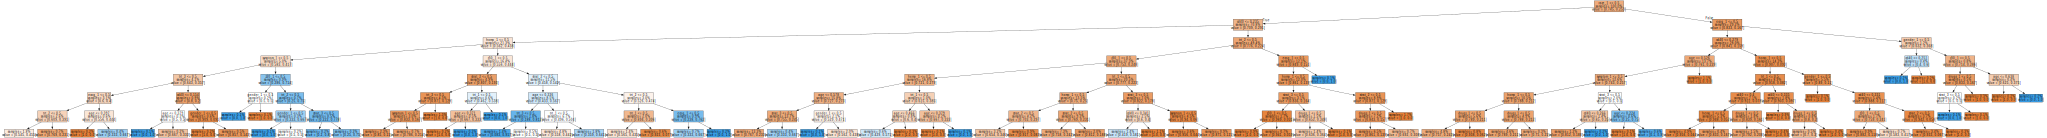

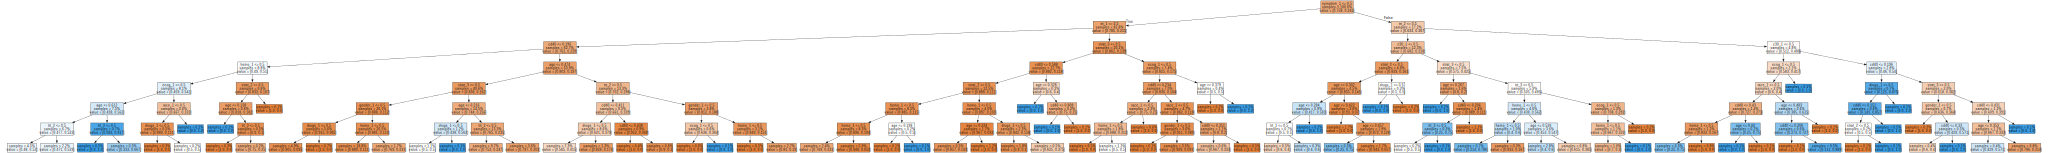

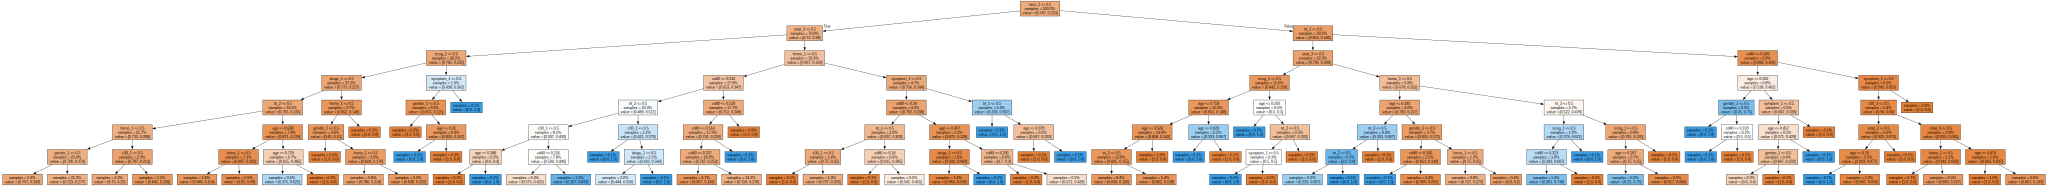

In [22]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=7, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

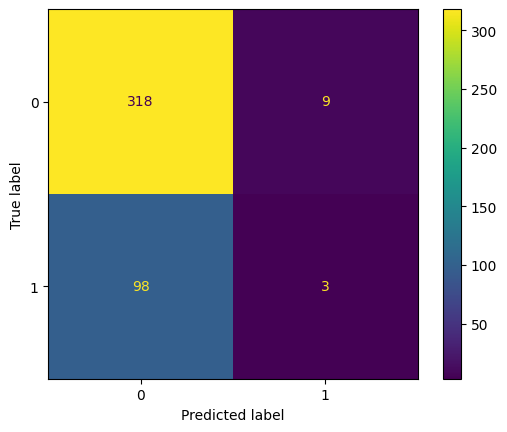

In [23]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

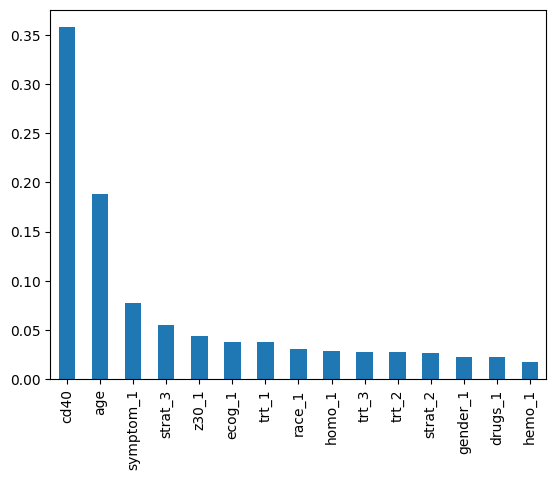

In [24]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

In [25]:
print(feature_importances)

cd40         0.357659
age          0.187814
symptom_1    0.077013
strat_3      0.054600
z30_1        0.043696
ecog_1       0.037693
trt_1        0.037614
race_1       0.031022
homo_1       0.028714
trt_3        0.027971
trt_2        0.027188
strat_2      0.026127
gender_1     0.022905
drugs_1      0.022049
hemo_1       0.017935
dtype: float64


A negative coefficient means that higher value of the corresponding feature pushes the classification more towards the negative class. 'negative class' ist in diesem Fall 'censoring' also 'überlebt'

# Datensatz 2. Reduktion

Nachfolgend werden die Features anhand von *feature importance / permutation* und nach inhaltlichen Überlegungen (domane Wissen) aus der Modellierung entfernt.

In [11]:
df.columns

Index(['age', 'cd40', 'cid', 'trt_1', 'trt_2', 'trt_3', 'homo_1', 'drugs_1',
       'z30_1', 'gender_1', 'strat_2', 'strat_3', 'symptom_1', 'hemo_1',
       'race_1', 'ecog_1'],
      dtype='object')

In [12]:
df2=df.drop(["hemo_1", "homo_1", "race_1", "ecog_1", "gender_1"],axis=1) #,

In [14]:
df2.head(7)

,age,cd40,cid,trt_1,trt_2,trt_3,drugs_1,z30_1,strat_2,strat_3,symptom_1
0,48,422,0,0,1,0,0,0,0,0,0
1,61,162,1,0,0,1,0,1,0,1,0
2,45,326,0,0,0,1,1,1,0,1,0
3,47,287,0,0,0,1,0,1,0,1,0
4,43,504,0,0,0,0,0,1,0,1,0
5,46,235,0,1,0,0,1,1,0,1,0
6,31,244,1,0,0,0,0,1,0,1,0


In [30]:
X2=df2.drop(['cid'],axis=1)
y2=df2['cid']

In [31]:
#from sklearn.model_selection import train_test_split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, shuffle=True, test_size=0.2,random_state=42)

print('X Train: {}'.format(X2_train.shape)) 
print('Y Train: {}'.format(y2_train.shape)) 
print('X Test: {}'.format(X2_test.shape)) 
print('Y Test: {}'.format(y2_test.shape))


X Train: (1711, 10)
Y Train: (1711,)
X Test: (428, 10)
Y Test: (428,)


## Transformierung mit MinMaxScaler

In [32]:
#from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X2_train['age'] = scaler.fit_transform(X2_train['age'].to_numpy().reshape(-1,1))
X2_train['cd40'] = scaler.fit_transform(X2_train['cd40'].to_numpy().reshape(-1,1))

X2_test['age'] = scaler.fit_transform(X2_test['age'].to_numpy().reshape(-1,1))
X2_test['cd40'] = scaler.fit_transform(X2_test['cd40'].to_numpy().reshape(-1,1))


## Hyperparameter

Die Suche nach optimalen `C`, `gamma`, `kernel`, `max_depth` und `n_estimators` wird auch im 2. Gang mittels Random_Search durchgeführt.

Per default ist Gamma 'scale', i.e. gamma = 1 / (n_features * X.var()). Es wird überlegt, die `gamma`='scale' statt dem optimierten Wert zu nehmen.

In [33]:
# für LogReg

logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,
                              random_state=0)
distributions = dict(C=uniform(loc=0, scale=4),
                     penalty=['l2', 'l1'])
clf0 = RandomizedSearchCV(logistic, distributions, random_state=42)
search = clf0.fit(X2_train, y2_train)

print("Die optimalen Hyperparameter für LogReg (Random Search):", search.best_params_)

Die optimalen Hyperparameter für LogReg (Random Search): {'C': np.float64(3.329770563201687), 'penalty': 'l1'}


In [34]:
# für SVM
param_dist = {
    'C': uniform(loc=0, scale=4),   #[0.1,1,10,100,1000]
    'gamma': [1,0.1,0.01,0.001,0.0001],
    'kernel': ['rbf', 'linear']
}

random_search = RandomizedSearchCV(SVC(random_state=42), param_dist, n_iter=10, refit=True,cv=5,verbose=0,random_state=42) #verbose = 0 : keine einzeln. Messages zu den fits
random_search.fit(X2_train,y2_train)

print("Die optimalen Hyperparameter für SVM (Random Seaarch):", random_search.best_params_)


Die optimalen Hyperparameter für SVM (Random Seaarch): {'C': np.float64(1.49816047538945), 'gamma': 0.0001, 'kernel': 'rbf'}


In [35]:
# für RF
param_dist = {'n_estimators': randint(10,300),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter=5, cv=5, random_state=42)

# Fit the random search object to the data
rand_search.fit(X2_train, y2_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000013D3AC5AF40>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000013D3AC27EB0>},
                   random_state=42)

In [36]:
best_rf2 = rand_search.best_estimator_

# Print the best hyperparameters
print('Die optimalen Hyperparameter für RF (Random Search):',  rand_search.best_params_)

Die optimalen Hyperparameter für RF (Random Search): {'max_depth': 7, 'n_estimators': 280}


## Die Auswahl des Classifikators

In [37]:
n_features = X.shape[1]

# Create different classifiers.
classifiers = {
    "L1 logistic": LogisticRegression(C=3.3, penalty="l1", solver="saga", max_iter=10000, random_state=42),
    
    "Linear SVC": SVC(kernel="linear", C=1.5, probability=True, random_state=42),
    
    "RBF SVC": SVC(kernel="rbf", C=1.5, gamma=0.0001, random_state=42),
    
    "Random Forest": RandomForestClassifier(max_depth=7, n_estimators=280, random_state=42)
}

for classifier_idx, (name, classifier) in enumerate(classifiers.items()):
    y2_pred = classifier.fit(X2_train, y2_train).predict(X2_test)
    accuracy2 = accuracy_score(y2_test, y2_pred)
    precision2 = precision_score(y2_test, y2_pred)
    recall2 = recall_score(y2_test, y2_pred)
    
    print(f"Akkuranz für {name}: {accuracy2:0.2%}")
    print(f"Relevanz für {name}: {precision2:0.2%}")
    print(f"Sensitivität für {name}: {recall2:0.2%}")
    

Akkuranz für L1 logistic: 75.70%
Relevanz für L1 logistic: 42.86%
Sensitivität für L1 logistic: 8.91%
Akkuranz für Linear SVC: 76.40%
Relevanz für Linear SVC: 0.00%
Sensitivität für Linear SVC: 0.00%
Akkuranz für RBF SVC: 76.40%
Relevanz für RBF SVC: 0.00%
Sensitivität für RBF SVC: 0.00%
Akkuranz für Random Forest: 74.30%
Relevanz für Random Forest: 26.32%
Sensitivität für Random Forest: 4.95%


### gamma = 'scale'

In [38]:
n_features = X.shape[1]

# Create different classifiers.
classifiers = {
    "L1 logistic": LogisticRegression(C=3.3, penalty="l1", solver="saga", max_iter=10000, random_state=42),
    
    "Linear SVC": SVC(kernel="linear", C=1.5, probability=True, random_state=42),
    
    "RBF SVC": SVC(kernel="rbf", C=1.5, gamma="scale", random_state=42),
    
    "Random Forest": RandomForestClassifier(max_depth=7, n_estimators=280, random_state=42)
}

for classifier_idx, (name, classifier) in enumerate(classifiers.items()):
    y2_pred = classifier.fit(X2_train, y2_train).predict(X2_test)
    accuracy2 = accuracy_score(y2_test, y2_pred)
    precision2 = precision_score(y2_test, y2_pred)
    recall2 = recall_score(y2_test, y2_pred)
    
    print(f"Akkuranz für {name}: {accuracy2:0.2%}")
    print(f"Relevanz für {name}: {precision2:0.2%}")
    print(f"Sensitivität für {name}: {recall2:0.2%}")
    

Akkuranz für L1 logistic: 75.70%
Relevanz für L1 logistic: 42.86%
Sensitivität für L1 logistic: 8.91%
Akkuranz für Linear SVC: 76.40%
Relevanz für Linear SVC: 0.00%
Sensitivität für Linear SVC: 0.00%
Akkuranz für RBF SVC: 75.00%
Relevanz für RBF SVC: 31.25%
Sensitivität für RBF SVC: 4.95%
Akkuranz für Random Forest: 74.30%
Relevanz für Random Forest: 26.32%
Sensitivität für Random Forest: 4.95%


Die Tendenz zu 'RBF SCV' mit `gamma`= 'scale' erhärtet sich. ==> bessere Precision und Recall.

<span style=color:green>Prefinale Entscheidung:</span> RBF SVC und Random Forest auf feature importnace / permutation importance anschauen. ==> Wenn kein großer Informationszugewinn erfolgt, das finale Modell wählen, evaluieren und fertigstellen.

## Support Vector Machine: RBF-Kernel

              precision    recall  f1-score   support

           0       0.97      0.77      0.86       412
           1       0.05      0.31      0.09        16

    accuracy                           0.75       428
   macro avg       0.51      0.54      0.47       428
weighted avg       0.93      0.75      0.83       428



Text(0.5, 0, 'Permutation Importance für das SVC-rbf')

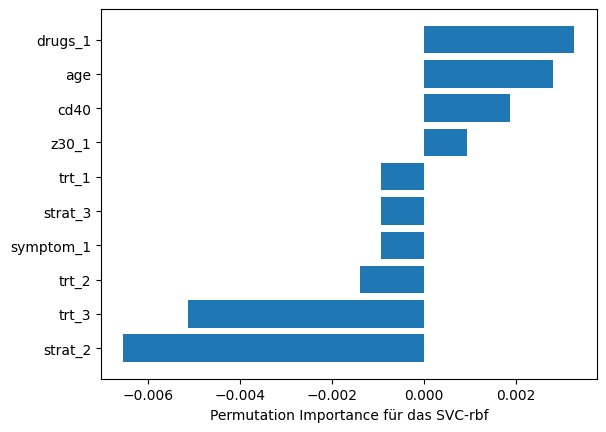

In [39]:
from sklearn.metrics import classification_report

clf2 =  SVC(kernel='rbf', C=1.5, gamma='scale', random_state=42)
clf2.fit(X2_train, y2_train)
y21_pred = clf2.predict(X2_test)

print(classification_report(y21_pred, y2_test))

perm_importance = permutation_importance(clf2, X2_test, y2_test)

feature_names2 = X2_train.columns
features2 = np.array(feature_names2)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features2[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance für das SVC-rbf")

#'permutation importance' gibt wieder, wie wichtig ein feature für das vorliegende Modell ist.
# bei RBF sind die 'coef' nicht verfügbar. - keine feature importance.

In [40]:
#Accuracy im Traings- und Testdatensatz
# wie gut wurde getrennt? Der Unterschied ist nicht groß == guter Spliting

print("Akkuranz Train: {}".format(clf2.score(X2_train, y2_train)))
print("Akkuranz Test: {}" .format(clf2.score(X2_test, y2_test)))

Akkuranz Train: 0.7644652250146113
Akkuranz Test: 0.75


Besserer Split mit dem reduzierten Datensatz.

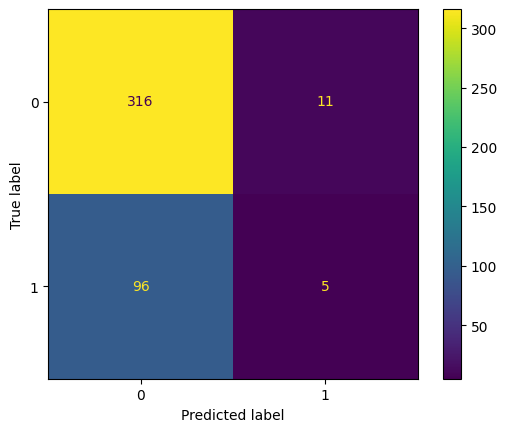

In [41]:
# Generate predictions with the best model
y21_pred = clf2.predict(X2_test)

# Create the confusion matrix
cm2 = confusion_matrix(y2_test, y21_pred)

ConfusionMatrixDisplay(cm2).plot();

## Random Forest

In [42]:
rf2 = RandomForestClassifier(max_depth=7, n_estimators=280, random_state=42)
rf2.fit(X2_train, y2_train)
y22_pred = rf2.predict(X2_test)
accuracy22 = accuracy_score(y2_test, y2_pred)

print("Akkuranz RF Modell:", accuracy22)

print(classification_report(y2_pred, y2_test))

Akkuranz RF Modell: 0.7429906542056075
              precision    recall  f1-score   support

           0       0.96      0.77      0.85       409
           1       0.05      0.26      0.08        19

    accuracy                           0.74       428
   macro avg       0.50      0.51      0.47       428
weighted avg       0.92      0.74      0.82       428



`classification_report` liefert **nach wie vor** maue *Precision* sowohl für SVM als auch für RF für das Target = 1 (failure). Das *recall* und die *support vectors* haben sich allerdings verbessert.

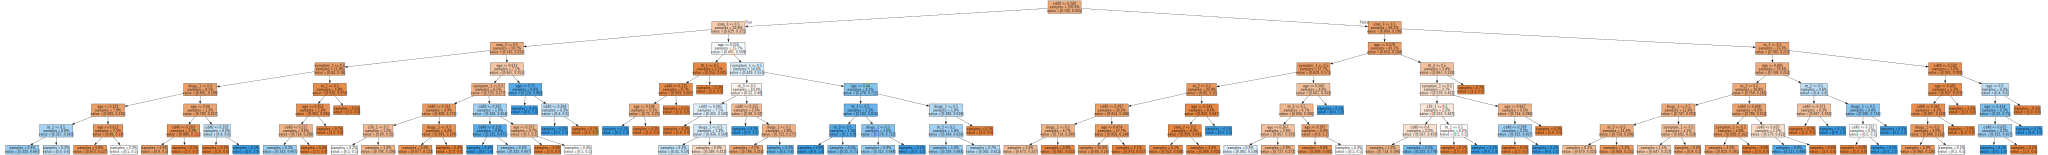

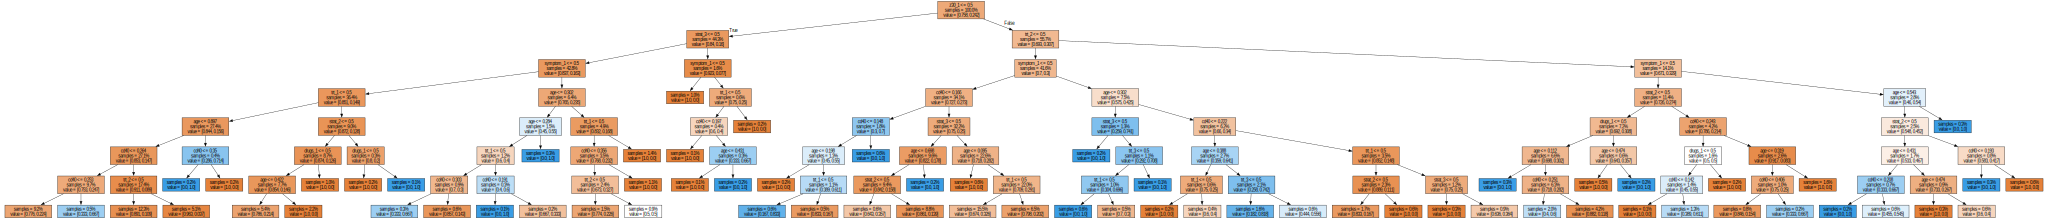

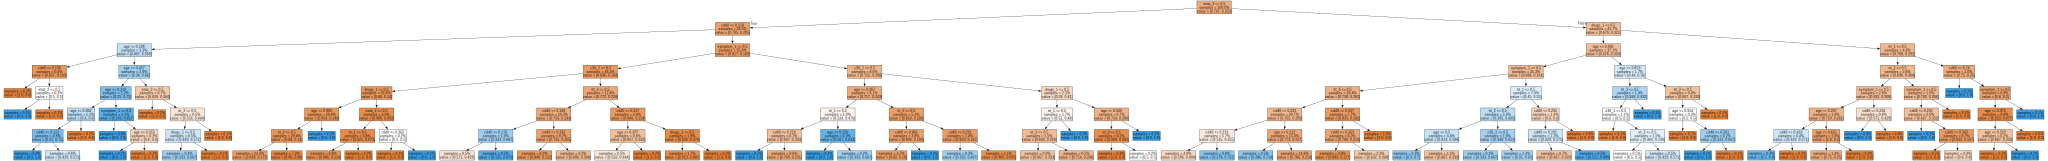

In [43]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = rf2.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X2_train.columns,  
                               filled=True,  
                               max_depth=7, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

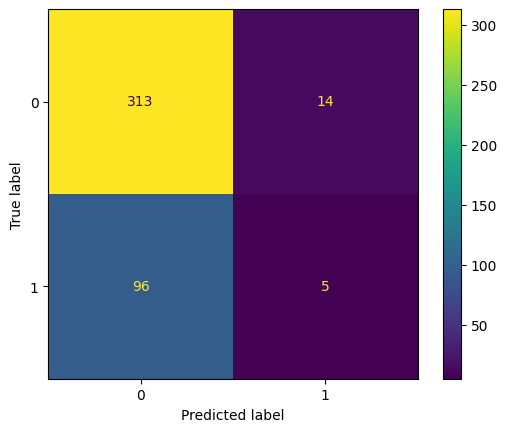

In [44]:
# Generate predictions with the best model
y23_pred = best_rf2.predict(X2_test)

# Create the confusion matrix
cm3 = confusion_matrix(y2_test, y2_pred)

ConfusionMatrixDisplay(cm3).plot();

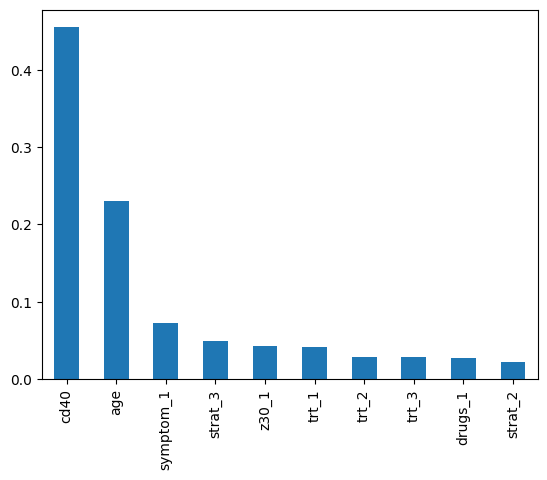

In [45]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances2 = pd.Series(best_rf2.feature_importances_, index=X2_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances2.plot.bar();

In [46]:
print(feature_importances2)

cd40         0.455104
age          0.230728
symptom_1    0.072408
strat_3      0.049602
z30_1        0.043260
trt_1        0.041878
trt_2        0.028929
trt_3        0.028166
drugs_1      0.027238
strat_2      0.022688
dtype: float64


A negative coefficient means that higher value of the corresponding feature pushes the classification more towards the negative class. 'negative class' ist in diesem Fall 'censoring' also 'überlebt'

# Evaluation, Modellentsheidung

### SVM

In [ ]:


clf2 =  SVC()
clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)

explainer = shap.Explainer(clf2)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

### Random Forest

In [ ]:
explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(X_test)

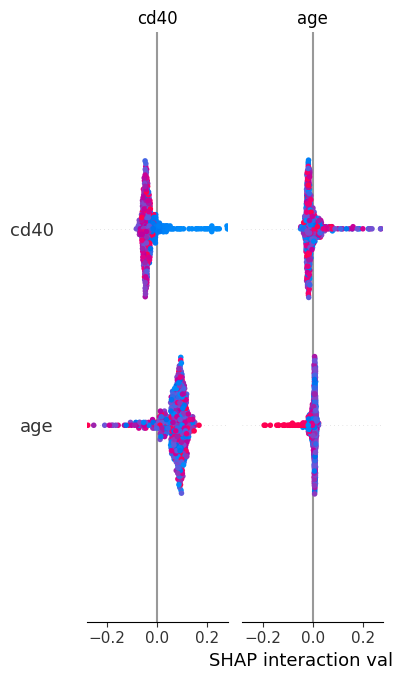

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.decision_plot(explainer.expected_value[1], shap_values[1], X_test.columns)

ValueError: The feature_names arg must include all features represented in shap_values.